preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    print(f"Shape data awal: {df.shape}")
    print(f"Kolom data: {df.columns.tolist()}")
    print(df.head())

    if 'created_at' not in df.columns:
        raise ValueError("Kolom 'created_at' tidak ditemukan dalam dataset.")

    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df.dropna(subset=['created_at'])
    df = df.sort_values('created_at').reset_index(drop=True)

    print(f"Rentang waktu: {df['created_at'].min()} sampai {df['created_at'].max()}")
    return df

In [3]:
def handle_missing_values(df):

    print("\n=== Analisis Missing Values ===")
    missing_info = df.isnull().sum()
    print(missing_info[missing_info > 0])
    
    # Untuk kolom numerik, gunakan interpolasi atau median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            # Gunakan interpolasi linear untuk time series
            df[col] = df[col].interpolate(method='linear')
            # Isi sisa dengan median
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [4]:
def detect_and_handle_outliers(df, method='iqr', threshold=3):
    print("\n=== Deteksi Outliers ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_info = {}

    mask = pd.Series([False] * len(df), index=df.index)

    for col in numeric_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)

        elif method == 'zscore':
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            outlier_mask = z_scores > threshold

        outliers = outlier_mask.sum()
        outlier_info[col] = outliers
        mask = mask | outlier_mask
        print(f"{col}: {outliers} outliers")

    df = df[~mask].reset_index(drop=True)
    return df, outlier_info


In [5]:
def feature_engineering(df):
    print("\n=== Feature Engineering ===")
    
    # Extract time features
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.dayofweek
    df['day_of_month'] = df['created_at'].dt.day
    
    # Rolling statistics (untuk menangkap trend)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'day_of_month']]
    
    window_sizes = [3, 5, 10]
    for window in window_sizes:
        for col in numeric_cols[:3]:  # Batasi untuk beberapa kolom utama
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
    
    # Lag features
    for col in numeric_cols[:3]:  # Batasi untuk beberapa kolom utama
        for lag in [1, 2, 3]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Hapus baris dengan NaN akibat lag features
    df = df.dropna().reset_index(drop=True)
    
    print(f"Shape setelah feature engineering: {df.shape}")
    return df

In [6]:
def normalize_features(df, scaler, fit=True, feature_columns=None):
    print("\n=== Normalisasi ===")
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if fit:
        scaled = scaler.fit_transform(df[cols])
        feature_columns = cols
    else:
        scaled = scaler.transform(df[feature_columns])
    
    df_scaled = df.copy()
    df_scaled[feature_columns] = scaled
    return df_scaled, feature_columns

In [7]:
def create_sequences(df, sequence_length=5, target_cols=None):
    print(f"\n=== Membuat Sequences (length={sequence_length}) ===")
    if target_cols is None:
        target_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    sequences = []
    timestamps = []
    for i in range(len(df) - sequence_length + 1):
        seq = df[target_cols].iloc[i:i+sequence_length].values
        sequences.append(seq)
        timestamps.append(df['created_at'].iloc[i+sequence_length-1])
    
    sequences = np.array(sequences)
    print(f"Shape sequences: {sequences.shape}")
    print(f"Jumlah sequences: {len(sequences)}")
    return sequences, timestamps

In [8]:
def split_data(sequences, timestamps, train_ratio=0.8):
    split = int(len(sequences) * train_ratio)
    X_train = sequences[:split]
    X_test = sequences[split:]
    train_timestamps = timestamps[:split]
    test_timestamps = timestamps[split:]
    print(f"\n=== Data Split ===")
    print(f"Training sequences: {X_train.shape}")
    print(f"Testing sequences: {X_test.shape}")
    return X_train, X_test, train_timestamps, test_timestamps

In [9]:
def plot_data_overview(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:6]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].plot(df['created_at'], df[col])
            axes[i].set_title(f'{col} over time')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [10]:
def main_preprocessing(file_path, sequence_length=10, scaler_type='minmax'):
    scaler = get_scaler(scaler_type)
    df = load_and_clean_data(file_path)
    df = handle_missing_values(df)
    df_dirty_with_anomaly= df
    df_scaled_dirty, feature_columns = normalize_features(df_dirty_with_anomaly, scaler, fit=True)
    sequencesdirty, timestampsdirty = create_sequences(df_scaled_dirty, sequence_length, target_cols=feature_columns)
    X_traindirty, X_testdirty, train_timestampsdirty, test_timestampsdirty = split_data(sequencesdirty, timestampsdirty)
    df, outlier_info = detect_and_handle_outliers(df)

    # df = feature_engineering(df)
    plot_data_overview(df)
    df_scaled, feature_columns = normalize_features(df, scaler, fit=True)
    sequences, timestamps = create_sequences(df_scaled, sequence_length, target_cols=feature_columns)
    X_train, X_test, train_timestamps, test_timestamps = split_data(sequences, timestamps)
    return {
        'X_train': X_train,
        'X_test': X_testdirty,
        'train_timestamps': train_timestamps,
        'test_timestamps': test_timestampsdirty,
        'feature_columns': feature_columns,
        'original_df': df,
        'scaled_df': df_scaled
    }

In [11]:
def get_scaler(scaler_type='standard'):
    if scaler_type == 'standard':
        return StandardScaler()
    elif scaler_type == 'minmax':
        return MinMaxScaler()
    elif scaler_type == 'robust':
        return RobustScaler()

MODEL CREATIONS

In [12]:
def build_lstm_autoencoder(timesteps, n_features, latent_dim=16):  # Kurangi dari 64 ke 32
    inputs = Input(shape=(timesteps, n_features))
    
    # ENCODER - Lebih konservatif
    # Layer 1: Kurangi neurons dan regularization
    encoded1 = LSTM(32,  # Kurangi dari 64 ke 32
                    activation='tanh',
                    dropout=0.3,  # Tingkatkan dropout
                    recurrent_dropout=0.3,
                    kernel_regularizer=l2(0.001),  # Kurangi regularization weight
                    return_sequences=True)(inputs)
    
    # Batch Normalization untuk stabilitas
    encoded1 = BatchNormalization()(encoded1)
    
    # Layer 2: Bottleneck yang lebih kecil
    encoded2 = LSTM(latent_dim,  # 16 instead of 32
                    activation='tanh',
                    dropout=0.3,
                    recurrent_dropout=0.3,
                    kernel_regularizer=l2(0.001))(encoded1)
    
    # Bottleneck representation
    repeated = RepeatVector(timesteps)(encoded2)
    
    # DECODER - Mirror structure
    # Layer 1: Gradual expansion
    decoded1 = LSTM(32,  # Match encoder
                    activation='tanh',
                    dropout=0.3,
                    recurrent_dropout=0.3,
                    return_sequences=True)(repeated)
    
    decoded1 = BatchNormalization()(decoded1)
    
    # Layer 2: Final reconstruction
    decoded2 = LSTM(n_features, 
                    activation='tanh',
                    return_sequences=True,
                    dropout=0.2)(decoded1)  # Sedikit kurangi dropout di layer akhir
    
    # Output layer tanpa dropout
    outputs = TimeDistributed(Dense(n_features, activation='linear'))(decoded2)
    
    model = Model(inputs, outputs)
    
    # Optimizer dengan decay
    optimizer = Adam(
        learning_rate=5e-5,  # Learning rate lebih kecil
        beta_1=0.9,
        beta_2=0.999,
        decay=1e-6  # Tambah weight decay
    )
    
    model.compile(
        optimizer=optimizer, 
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [13]:
def create_advanced_visualizations(history, train_mae, test_mae, train_repr, test_repr,
                                 thresholds, X_train, X_train_pred, X_test, X_test_pred,
                                 y_train=None, y_test=None):
    """Create comprehensive visualizations"""
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training History
    plt.subplot(3, 4, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Reconstruction Error Distribution
    plt.subplot(3, 4, 2)
    plt.hist(train_mae, bins=50, alpha=0.7, label='Train MAE', density=True)
    plt.hist(test_mae, bins=50, alpha=0.7, label='Test MAE', density=True)
    
    # Plot thresholds
    colors = ['red', 'orange', 'purple']
    threshold_names = ['mae_percentile', 'mae_mean_std', 'mae_iqr']
    for i, name in enumerate(threshold_names):
        if name in thresholds:
            plt.axvline(thresholds[name], color=colors[i], linestyle='--', 
                       label=f'{name}: {thresholds[name]:.4f}')
    
    plt.xlabel('Reconstruction Error (MAE)')
    plt.ylabel('Density')
    plt.title('Error Distribution with Thresholds', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. Box Plot of Errors
    plt.subplot(3, 4, 3)
    data_to_plot = [train_mae, test_mae]
    labels = ['Train', 'Test']
    if y_train is not None and y_test is not None:
        # Separate normal and anomaly if labels available
        normal_train = train_mae[y_train == 0] if len(y_train) > 0 else train_mae
        normal_test = test_mae[y_test == 0] if len(y_test) > 0 else test_mae
        anomaly_test = test_mae[y_test == 1] if len(y_test) > 0 and np.any(y_test == 1) else []
        
        data_to_plot = [normal_train, normal_test]
        labels = ['Train Normal', 'Test Normal']
        if len(anomaly_test) > 0:
            data_to_plot.append(anomaly_test)
            labels.append('Test Anomaly')
    
    plt.boxplot(data_to_plot, labels=labels)
    plt.ylabel('Reconstruction Error (MAE)')
    plt.title('Error Distribution Comparison', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Representations Scatter Plot (2D projection)
    plt.subplot(3, 4, 4)
    try:
        # Handle different representation shapes
        if train_repr.ndim > 2:
            train_repr_2d = train_repr.reshape(train_repr.shape[0], -1)
            test_repr_2d = test_repr.reshape(test_repr.shape[0], -1)
        else:
            train_repr_2d = train_repr
            test_repr_2d = test_repr
            
        if train_repr_2d.shape[1] >= 2:
            plt.scatter(train_repr_2d[:, 0], train_repr_2d[:, 1], alpha=0.6, s=20, label='Train')
            plt.scatter(test_repr_2d[:, 0], test_repr_2d[:, 1], alpha=0.6, s=20, label='Test')
            plt.xlabel('Latent Dimension 1')
            plt.ylabel('Latent Dimension 2')
        elif train_repr_2d.shape[1] == 1:
            # 1D representation
            plt.scatter(range(len(train_repr_2d)), train_repr_2d[:, 0], alpha=0.6, s=20, label='Train')
            plt.scatter(range(len(test_repr_2d)), test_repr_2d[:, 0], alpha=0.6, s=20, label='Test')
            plt.xlabel('Sample Index')
            plt.ylabel('Latent Value')
        else:
            # If no proper dimensions, show a simple plot
            plt.text(0.5, 0.5, 'Representation\nvisualization\nnot available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.title('Latent Space Representations', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create representation scatter plot: {e}")
        plt.text(0.5, 0.5, f'Representation plot\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Representations', fontweight='bold')
    
    # 5. Reconstruction Quality Samples
    plt.subplot(3, 4, 5)
    n_samples = min(5, X_test.shape[0])
    sample_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        plt.plot(X_test[idx, :, 0], alpha=0.7, label=f'Original {i+1}' if i < 2 else "")
        plt.plot(X_test_pred[idx, :, 0], '--', alpha=0.7, label=f'Reconstructed {i+1}' if i < 2 else "")
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Original vs Reconstructed Samples', fontweight='bold')
    if n_samples <= 2:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Error Time Series
    plt.subplot(3, 4, 6)
    plt.plot(test_mae, alpha=0.8, linewidth=1)
    plt.axhline(thresholds['mae_percentile'], color='red', linestyle='--', 
                label=f'Threshold: {thresholds["mae_percentile"]:.4f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (MAE)')
    plt.title('Test Error Time Series', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Latent Space Heatmap
    plt.subplot(3, 4, 7)
    try:
        if train_repr.ndim > 2:
            # Flatten if needed
            train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
        else:
            train_repr_flat = train_repr
            
        if train_repr_flat.shape[1] > 1 and train_repr_flat.shape[1] <= 50:  # Reasonable limit for correlation matrix
            # Show correlation matrix of latent dimensions
            corr_matrix = np.corrcoef(train_repr_flat.T)
            if not np.isnan(corr_matrix).all():  # Check if correlation matrix is valid
                sns.heatmap(corr_matrix, annot=True if train_repr_flat.shape[1] <= 10 else False, 
                           cmap='coolwarm', center=0, square=True, 
                           cbar_kws={'label': 'Correlation'})
                plt.title('Latent Dimensions Correlation', fontweight='bold')
            else:
                # Fallback to histogram
                plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7)
                plt.xlabel('Latent Value')
                plt.ylabel('Frequency')
                plt.title('Latent Space Distribution', fontweight='bold')
                plt.grid(True, alpha=0.3)
        else:
            # For single dimension or too many dimensions, show distribution
            plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7)
            plt.xlabel('Latent Value')
            plt.ylabel('Frequency')
            plt.title('Latent Space Distribution', fontweight='bold')
            plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create latent space visualization: {e}")
        plt.text(0.5, 0.5, f'Latent visualization\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Analysis', fontweight='bold')
    
    # 8. Feature Importance (Reconstruction Error by Feature)
    plt.subplot(3, 4, 8)
    feature_errors = np.mean(np.abs(X_test - X_test_pred), axis=(0, 1))
    plt.bar(range(len(feature_errors)), feature_errors)
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Absolute Error')
    plt.title('Feature-wise Reconstruction Error', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 9-12. Additional plots if space allows
    if y_test is not None and np.any(y_test == 1):
        # ROC Curve would go here
        plt.subplot(3, 4, 9)
        normal_errors = test_mae[y_test == 0]
        anomaly_errors = test_mae[y_test == 1]
        
        plt.hist(normal_errors, bins=30, alpha=0.7, label='Normal', density=True)
        plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Anomaly', density=True)
        plt.axvline(thresholds['mae_percentile'], color='red', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Density')
        plt.title('Normal vs Anomaly Distribution', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
def evaluate_anomaly_detection(train_mae, test_mae, y_train, y_test, thresholds):
    """Evaluate anomaly detection performance"""
    from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
    
    results = {}
    
    for threshold_name, threshold_value in thresholds.items():
        if 'mae' in threshold_name:
            predictions = (test_mae > threshold_value).astype(int)
            
            try:
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_test, predictions, average='binary', zero_division=0
                )
                auc_score = roc_auc_score(y_test, test_mae)
                
                results[threshold_name] = {
                    'threshold': threshold_value,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc_score,
                    'predictions': predictions
                }
                
                print(f"\n📈 Performance with {threshold_name}:")
                print(f"  Precision: {precision:.4f}")
                print(f"  Recall: {recall:.4f}")
                print(f"  F1-Score: {f1:.4f}")
                print(f"  AUC: {auc_score:.4f}")
                
            except Exception as e:
                print(f"Error evaluating {threshold_name}: {e}")
    
    return results

In [15]:
def train_advanced_lstm_autoencoder(X_train, X_test, y_train=None, y_test=None, 
                                  epochs=300, batch_size=32, patience=10, 
                                  threshold_percentile=95, verbose=1):   
    timesteps = X_train.shape[1]
    n_features = X_train.shape[2]
    
    print(f"Data shape: {X_train.shape}")
    print(f"Timesteps: {timesteps}, Features: {n_features}")
    
    # Build model (assuming build_lstm_autoencoder function exists)
    model = build_lstm_autoencoder(timesteps, n_features)
    import pickle
    
    # Save model
    # Advanced callbacks
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=patience//2,
        min_lr=1e-7,
        verbose=1
    )
    
    # Training
    print("\n🚀 Starting training...")
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test),
        callbacks=[early_stop, reduce_lr],
        shuffle=False,
        verbose=verbose
    )
    
    # Get encoder model for representations
    # Find the bottleneck/encoding layer (usually the middle layer with smallest dimension)
    encoder_output = None
    min_units = float('inf')
    
    for i, layer in enumerate(model.layers):
        # Look for Dense layers that could be the bottleneck
        if hasattr(layer, 'units'):
            if layer.units < min_units:
                min_units = layer.units
                encoder_output = layer.output
        # Also check for LSTM layers in the encoder part
        elif 'lstm' in layer.name.lower() and i < len(model.layers) // 2:
            encoder_output = layer.output
    
    # If no specific encoder found, use middle layer
    if encoder_output is None:
        middle_idx = len(model.layers) // 2
        encoder_output = model.layers[middle_idx].output
    
    # Create encoder model
    encoder = Model(inputs=model.input, outputs=encoder_output)
    
    # Get predictions and representations
    print("\n🔍 Generating predictions and representations...")
    X_train_pred = model.predict(X_train, verbose=0)
    X_test_pred = model.predict(X_test, verbose=0)
    
    # Get encoded representations
    train_representations = encoder.predict(X_train, verbose=0)
    test_representations = encoder.predict(X_test, verbose=0)
    
    # Flatten representations if they have more than 2 dimensions
    if len(train_representations.shape) > 2:
        train_representations = train_representations.reshape(train_representations.shape[0], -1)
        test_representations = test_representations.reshape(test_representations.shape[0], -1)
    
    print(f"Representation shape: {train_representations.shape}")
    
    # Calculate reconstruction errors
    train_mae = np.mean(np.abs(X_train - X_train_pred), axis=(1, 2))
    test_mae = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))
    
    train_mse = np.mean(np.square(X_train - X_train_pred), axis=(1, 2))
    test_mse = np.mean(np.square(X_test - X_test_pred), axis=(1, 2))
    
    # Automatic threshold calculation
    thresholds = {
        'mae_mean_std': np.mean(train_mae) + 2 * np.std(train_mae),
        'mae_percentile': np.percentile(train_mae, threshold_percentile),
        'mse_mean_std': np.mean(train_mse) + 2 * np.std(train_mse),
        'mse_percentile': np.percentile(train_mse, threshold_percentile),
        'mae_iqr': np.percentile(train_mae, 75) + 1.5 * (np.percentile(train_mae, 75) - np.percentile(train_mae, 25))
    }
    
    # Calculate metrics
    metrics = {
        'train_mae_mean': np.mean(train_mae),
        'train_mae_std': np.std(train_mae),
        'test_mae_mean': np.mean(test_mae),
        'test_mae_std': np.std(test_mae),
        'train_mse_mean': np.mean(train_mse),
        'test_mse_mean': np.mean(test_mse)
    }
    
    print(f"\n📊 Reconstruction Error Statistics:")
    print(f"Training MAE: {metrics['train_mae_mean']:.5f} ± {metrics['train_mae_std']:.5f}")
    print(f"Test MAE: {metrics['test_mae_mean']:.5f} ± {metrics['test_mae_std']:.5f}")
    
    print(f"\n🎯 Automatic Thresholds:")
    for name, threshold in thresholds.items():
        print(f"{name}: {threshold:.5f}")
    
    # Visualization
    create_advanced_visualizations(
        history, train_mae, test_mae, train_representations, test_representations,
        thresholds, X_train, X_train_pred, X_test, X_test_pred, y_train, y_test
    )
    
    # Anomaly detection if labels provided
    anomaly_results = {}
    if y_train is not None and y_test is not None:
        anomaly_results = evaluate_anomaly_detection(
            train_mae, test_mae, y_train, y_test, thresholds
        )
    
    # Prepare results
    results = {
        'model': model,
        'encoder': encoder,
        'history': history,
        'thresholds': thresholds,
        'metrics': metrics,
        'train_errors': {'mae': train_mae, 'mse': train_mse},
        'test_errors': {'mae': test_mae, 'mse': test_mse},
        'representations': {
            'train': train_representations,
            'test': test_representations
        },
        'predictions': {
            'train': X_train_pred,
            'test': X_test_pred
        },
        'anomaly_results': anomaly_results
    }
    
    return results

SAVE MODELS

In [16]:
def save_model_with_threshold(model, threshold, model_name='lstm_autoencoder'):
    """
    Simpan model + threshold anomaly detection
    """
    import pickle
    
    # Save model
    model.save(f'{model_name}.keras')
    
    # Save threshold
    with open(f'{model_name}_threshold.pkl', 'wb') as f:
        pickle.dump(threshold, f)
    
    print(f"✅ Model disimpan: {model_name}.keras")
    print(f"✅ Threshold disimpan: {model_name}_threshold.pkl")

MAIN FUNCTION

Shape data awal: (8800, 9)
Kolom data: ['fw_load_avg_1_min', 'fw_load_avg_5_min', 'fw_load_avg_15_min', 'fw_cpu_used', 'mem_used', 'root_used', 'log_used', 'fw_total_alloc', 'created_at']
   fw_load_avg_1_min  fw_load_avg_5_min  fw_load_avg_15_min  fw_cpu_used  \
0               0.20               0.15                0.17            0   
1               0.22               0.24                0.23            0   
2               0.30               0.25                0.21            1   
3               0.24               0.23                0.21            1   
4               0.10               0.21                0.20            0   

   mem_used  root_used  log_used  fw_total_alloc               created_at  
0   7917172   10093296  10308548       648786522  2024-11-06 14:05:47.407  
1   7913424   10093272  10308720       648678277  2024-11-06 13:46:37.290  
2   7913156   10093292  10308316       648648252  2024-11-06 13:41:26.903  
3   7922540   10093292  10308316       648644738  2

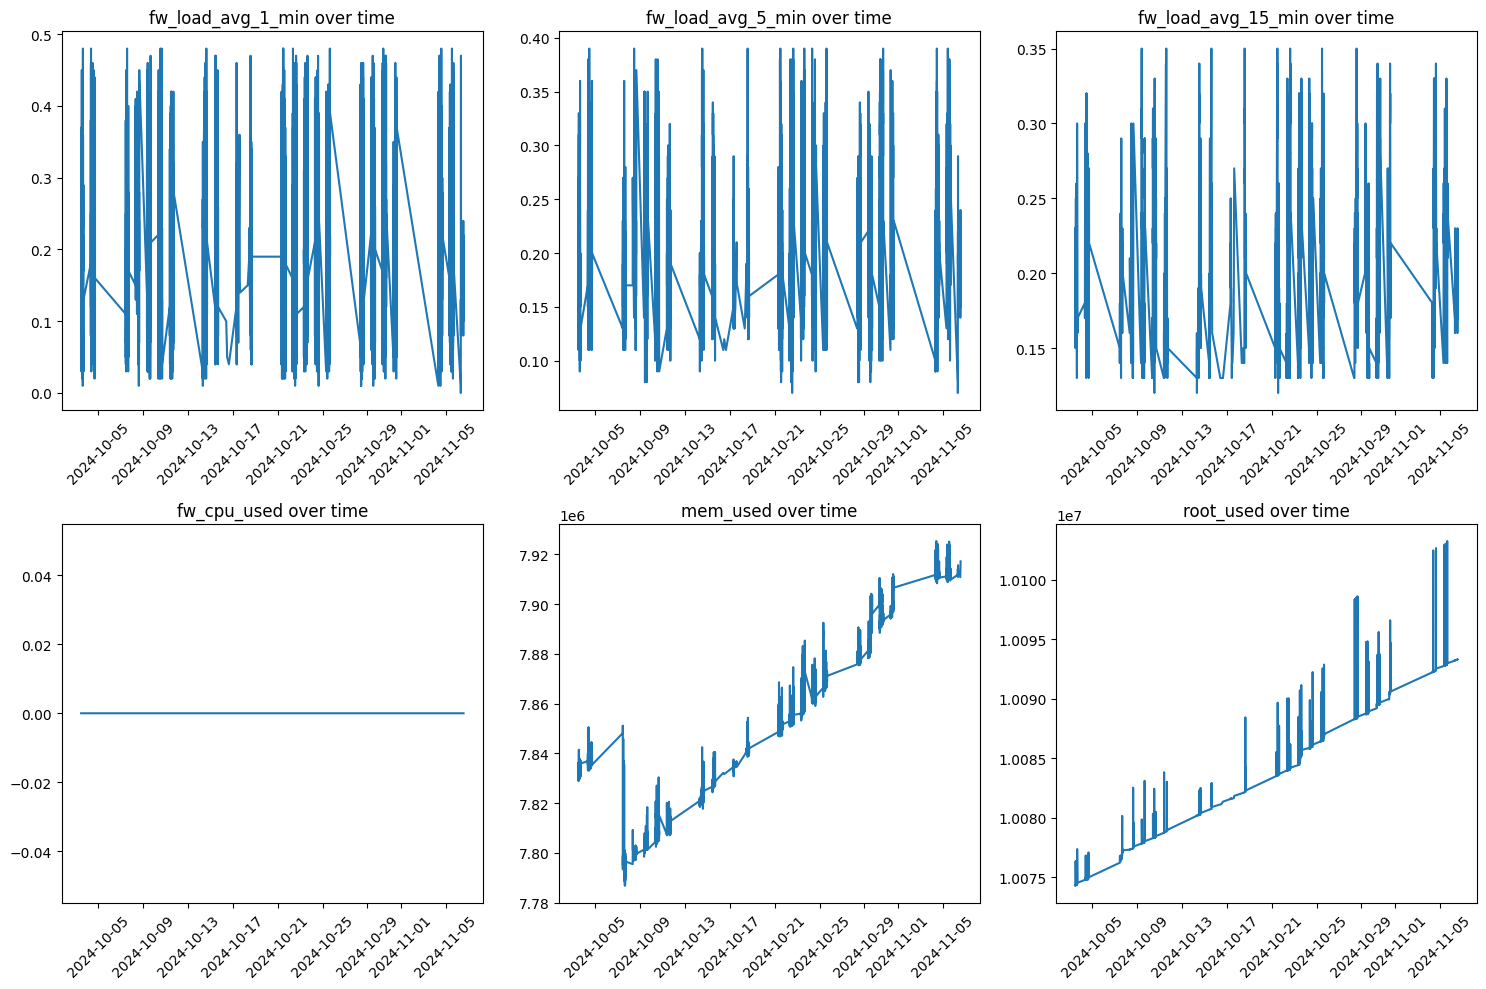

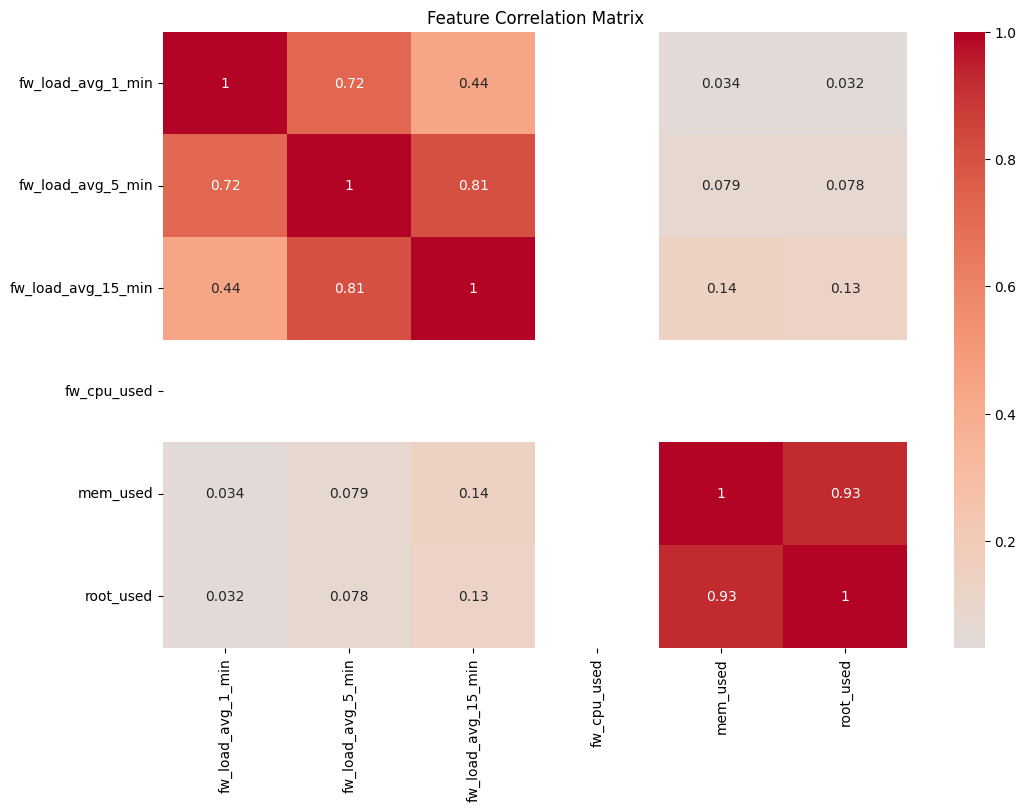


=== Normalisasi ===

=== Membuat Sequences (length=10) ===
Shape sequences: (8165, 10, 8)
Jumlah sequences: 8165

=== Data Split ===
Training sequences: (6532, 10, 8)
Testing sequences: (1633, 10, 8)


In [17]:
file_path = "datas.csv"

results = main_preprocessing(file_path)



Data shape: (6532, 10, 8)
Timesteps: 10, Features: 8

🚀 Starting training...
Epoch 1/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - loss: 0.2850 - mae: 0.3806 - val_loss: 0.3969 - val_mae: 0.4515 - learning_rate: 5.0000e-05
Epoch 2/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2377 - mae: 0.3384 - val_loss: 0.4435 - val_mae: 0.4645 - learning_rate: 5.0000e-05
Epoch 3/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2073 - mae: 0.3091 - val_loss: 0.4180 - val_mae: 0.4515 - learning_rate: 5.0000e-05
Epoch 4/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1859 - mae: 0.2858 - val_loss: 0.3611 - val_mae: 0.4261 - learning_rate: 5.0000e-05
Epoch 5/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1690 - mae: 0.2665 - val_loss: 0.3119 - val_mae: 0.3989 - learning_rate: 5.0000e-05
Epoch 6/300
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1553 - mae: 0.2499 - val_loss: 0.2732 - val_mae: 0.3754 - learning_rate: 5.0000e-05
Epoch 7/300
205/205 ━━━━━━━━━━━━━━

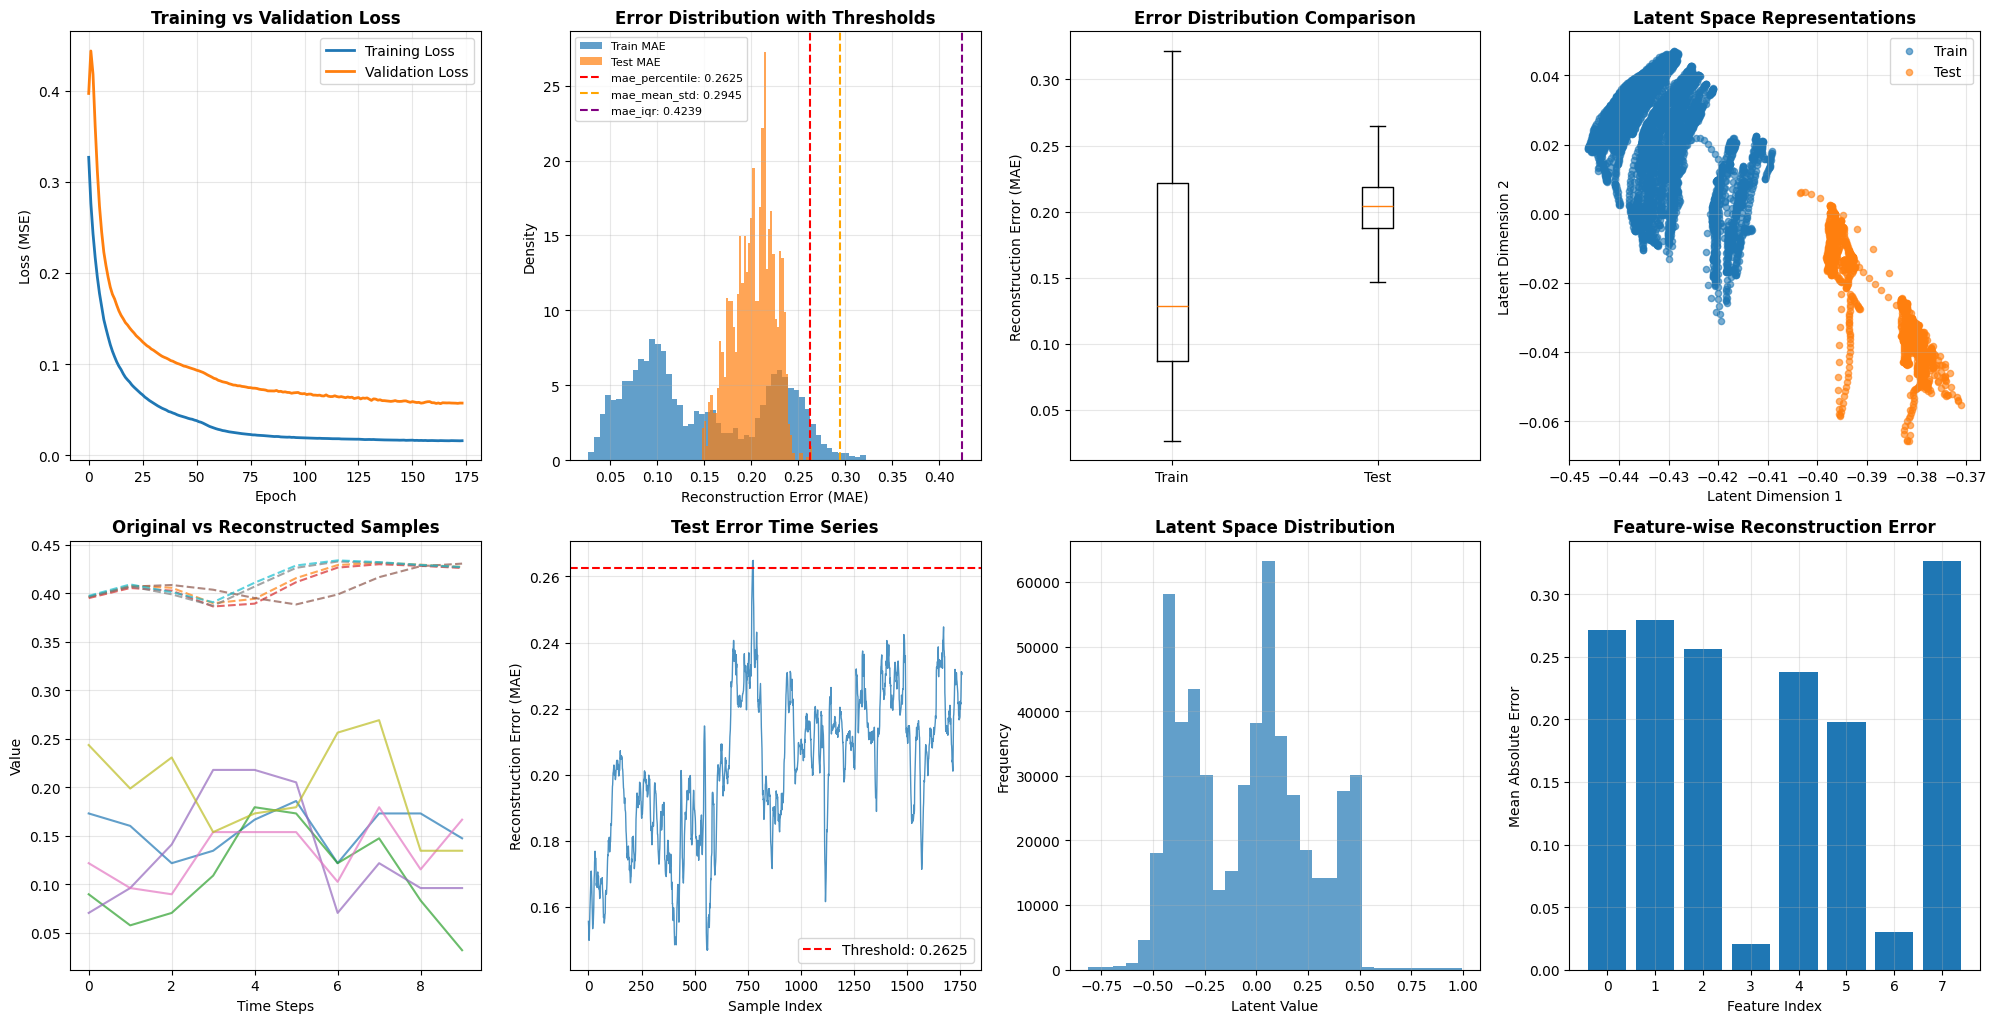

In [18]:
model_results = train_advanced_lstm_autoencoder(results['X_train'], results['X_test'])

In [19]:
save_model_with_threshold(model_results['model'],model_results['thresholds'])

✅ Model disimpan: lstm_autoencoder.keras
✅ Threshold disimpan: lstm_autoencoder_threshold.pkl


ANOMALY ANALYSIS

In [20]:
def visualize_anomaly_detection(results, X_test, anomaly_indices, normal_indices, 
                               threshold, test_errors, timestamps=None, feature_names=None):
    """
    Create comprehensive visualizations for anomaly detection results
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Anomaly Detection Analysis', fontsize=16, fontweight='bold')
    
    # 1. Error distribution with anomalies highlighted
    ax = axes[0, 0]
    ax.hist(test_errors[normal_indices], bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    ax.hist(test_errors[anomaly_indices], bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
    ax.axvline(threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    ax.set_xlabel('Reconstruction Error (MAE)')
    ax.set_ylabel('Density')
    ax.set_title('Error Distribution: Normal vs Anomaly')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Time series of errors with anomalies marked
    ax = axes[0, 1]
    if timestamps is not None:
        ax.plot(timestamps, test_errors, alpha=0.7, linewidth=1, label='Reconstruction Error')
        ax.scatter(timestamps[anomaly_indices], test_errors[anomaly_indices], 
                  color='red', s=50, alpha=0.8, label='Anomalies', zorder=5)
        ax.set_xlabel('Timestamp')
    else:
        ax.plot(test_errors, alpha=0.7, linewidth=1, label='Reconstruction Error')
        ax.scatter(anomaly_indices, test_errors[anomaly_indices], 
                  color='red', s=50, alpha=0.8, label='Anomalies', zorder=5)
        ax.set_xlabel('Sample Index')
    
    ax.axhline(threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    ax.set_ylabel('Reconstruction Error')
    ax.set_title('Anomaly Detection Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    if timestamps is not None:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Box plot comparison
    ax = axes[0, 2]
    data_to_plot = [test_errors[normal_indices], test_errors[anomaly_indices]]
    labels = ['Normal', 'Anomaly']
    box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    ax.set_ylabel('Reconstruction Error')
    ax.set_title('Error Distribution Comparison')
    ax.grid(True, alpha=0.3)
    
    # 4. Sample reconstructions (normal vs anomaly)
    ax = axes[1, 0]
    if len(anomaly_indices) > 0 and len(normal_indices) > 0:
        # Pick one normal and one anomaly sample
        normal_idx = normal_indices[0]
        anomaly_idx = anomaly_indices[0]
        
        # Plot original vs reconstructed for normal sample
        ax.plot(X_test[normal_idx, :, 0], label='Normal Original', alpha=0.8, linewidth=2)
        normal_pred = results['predictions']['test'][normal_idx, :, 0]
        ax.plot(normal_pred, '--', label='Normal Reconstructed', alpha=0.8, linewidth=2)
        
        # Plot original vs reconstructed for anomaly sample
        ax.plot(X_test[anomaly_idx, :, 0], label='Anomaly Original', alpha=0.8, linewidth=2)
        anomaly_pred = results['predictions']['test'][anomaly_idx, :, 0]
        ax.plot(anomaly_pred, '--', label='Anomaly Reconstructed', alpha=0.8, linewidth=2)
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.set_title(f'Sample Reconstructions\n(Normal: {normal_idx}, Anomaly: {anomaly_idx})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 5. Feature-wise error analysis for anomalies
    ax = axes[1, 1]
    if len(anomaly_indices) > 0:
        # Calculate mean error per feature for anomalies
        anomaly_samples = X_test[anomaly_indices]
        anomaly_predictions = results['predictions']['test'][anomaly_indices]
        feature_errors = np.mean(np.abs(anomaly_samples - anomaly_predictions), axis=(0, 1))
        
        if feature_names is not None and len(feature_names) == len(feature_errors):
            x_labels = feature_names
        else:
            x_labels = [f'Feature {i}' for i in range(len(feature_errors))]
        
        bars = ax.bar(range(len(feature_errors)), feature_errors, alpha=0.7, color='coral')
        ax.set_xlabel('Features')
        ax.set_ylabel('Mean Absolute Error')
        ax.set_title('Feature-wise Error in Anomalies')
        ax.set_xticks(range(len(feature_errors)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, error in zip(bars, feature_errors):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{error:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 6. Severity analysis
    ax = axes[1, 2]
    if len(anomaly_indices) > 0:
        severity_scores = [(test_errors[idx] - threshold) / threshold for idx in anomaly_indices]
        ax.hist(severity_scores, bins=20, alpha=0.7, color='red', edgecolor='black')
        ax.set_xlabel('Severity Score')
        ax.set_ylabel('Frequency')
        ax.set_title('Anomaly Severity Distribution')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_severity = np.mean(severity_scores)
        ax.axvline(mean_severity, color='orange', linestyle='--', 
                  label=f'Mean Severity: {mean_severity:.2f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [21]:
def get_anomaly_samples(results, X_test, threshold_method='mae_percentile', top_n=5):
    
    threshold = results['thresholds'][threshold_method]
    test_errors = results['test_errors']['mae']
    
    # Get anomalies
    anomaly_mask = test_errors > threshold
    anomaly_indices = np.where(anomaly_mask)[0]
    
    # Sort by error (highest first)
    sorted_indices = anomaly_indices[np.argsort(test_errors[anomaly_indices])[::-1]]
    
    # Get top N
    top_anomalies = sorted_indices[:top_n]
    
    anomaly_samples = {}
    for i, idx in enumerate(top_anomalies):
        anomaly_samples[f'anomaly_{i+1}'] = {
            'index': idx,
            'error': test_errors[idx],
            'original_data': X_test[idx],
            'reconstructed_data': results['predictions']['test'][idx],
            'difference': X_test[idx] - results['predictions']['test'][idx]
        }
    
    return anomaly_samples

In [22]:
def detect_and_analyze_anomalies(results, X_test, threshold_method='mae_percentile', 
                               original_data=None, timestamps=None, feature_names=None):
    
    # Get threshold and errors
    threshold = results['thresholds'][threshold_method]
    test_errors = results['test_errors']['mae']
    
    # Detect anomalies
    anomaly_mask = test_errors > threshold
    anomaly_indices = np.where(anomaly_mask)[0]
    normal_indices = np.where(~anomaly_mask)[0]
    
    print(f"🎯 Anomaly Detection Results using {threshold_method}")
    print(f"Threshold: {threshold:.5f}")
    print(f"📊 Summary:")
    print(f"  Total samples: {len(test_errors)}")
    print(f"  Anomalies detected: {len(anomaly_indices)} ({len(anomaly_indices)/len(test_errors)*100:.2f}%)")
    print(f"  Normal samples: {len(normal_indices)} ({len(normal_indices)/len(test_errors)*100:.2f}%)")
    print(f"  Min error: {np.min(test_errors):.5f}")
    print(f"  Max error: {np.max(test_errors):.5f}")
    print(f"  Mean error: {np.mean(test_errors):.5f}")
    
    # Create detailed anomaly report
    anomaly_details = []
    for idx in anomaly_indices:
        detail = {
            'sample_index': idx,
            'reconstruction_error': test_errors[idx],
            'error_above_threshold': test_errors[idx] - threshold,
            'severity_score': (test_errors[idx] - threshold) / threshold,  # Relative severity
        }
        
        if timestamps is not None and len(timestamps) > idx:
            detail['timestamp'] = timestamps[idx]
        
        if original_data is not None:
            detail['original_values'] = original_data[idx] if len(original_data.shape) == 2 else original_data[idx].flatten()
        
        anomaly_details.append(detail)
    
    # Sort by reconstruction error (most anomalous first)
    anomaly_details.sort(key=lambda x: x['reconstruction_error'], reverse=True)
    
    # Print top anomalies
    print(f"\n🔍 Top 10 Most Anomalous Samples:")
    print(f"{'Index':<8} {'Error':<12} {'Above Thresh':<12} {'Severity':<10} {'Timestamp':<20}")
    print("-" * 70)
    
    for i, detail in enumerate(anomaly_details[:10]):
        timestamp_str = str(detail.get('timestamp', 'N/A'))[:19]  # Limit timestamp length
        print(f"{detail['sample_index']:<8} {detail['reconstruction_error']:<12.5f} "
              f"{detail['error_above_threshold']:<12.5f} {detail['severity_score']:<10.2f} {timestamp_str:<20}")
    
    # Create visualization

    
    # Prepare return dictionary
    anomaly_analysis = {
        'threshold_used': threshold,
        'threshold_method': threshold_method,
        'anomaly_indices': anomaly_indices,
        'normal_indices': normal_indices,
        'anomaly_details': anomaly_details,
        'statistics': {
            'total_samples': len(test_errors),
            'anomaly_count': len(anomaly_indices),
            'anomaly_percentage': len(anomaly_indices)/len(test_errors)*100,
            'min_error': np.min(test_errors),
            'max_error': np.max(test_errors),
            'mean_error': np.mean(test_errors),
            'std_error': np.std(test_errors)
        }
    }
    
    return anomaly_analysis

In [23]:
anomaly_analysis = detect_and_analyze_anomalies(
    model_results,
    results['X_test'],
    threshold_method='mae_percentile',
    timestamps=results['test_timestamps'],
)

# Lihat hasil
print("Anomaly detection completed!")

🎯 Anomaly Detection Results using mae_percentile
Threshold: 0.26252
📊 Summary:
  Total samples: 1759
  Anomalies detected: 4 (0.23%)
  Normal samples: 1755 (99.77%)
  Min error: 0.14696
  Max error: 0.26485
  Mean error: 0.20244

🔍 Top 10 Most Anomalous Samples:
Index    Error        Above Thresh Severity   Timestamp           
----------------------------------------------------------------------
776      0.26485      0.00233      0.01       2024-11-04 09:51:13 
773      0.26463      0.00210      0.01       2024-11-04 09:48:13 
775      0.26331      0.00078      0.00       2024-11-04 09:50:13 
774      0.26292      0.00040      0.00       2024-11-04 09:49:13 
Anomaly detection completed!
